In [1]:
# Import Data Science libraries for Data Analysis, Visualization, and Plotting
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

# Import adfuller for stationarity test
from statsmodels.tsa.stattools import adfuller

# Import seasonal decompose function from statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose

# Import plot_acf from Statsmodels to calculate Autocorrelation Function
from statsmodels.graphics.tsaplots import plot_acf

# Import auto_arima for future trend analysis
from pmdarima import auto_arima

# Import statsmodels for SARIMAX modelling 
import statsmodels.api as sm

# Import sklearn for Root Mean Square calculations
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Setup plotting
plt.style.use('ggplot')
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Skip warning messages for clarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load WGU provided dataset into Pandas dataframe
teleco_df = pd.read_csv('teleco_time_series.csv')

In [3]:
# Exploration - View header of dataframe
teleco_df.head(10)

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
5,6,0.107654
6,7,0.493901
7,8,0.376698
8,9,0.304075
9,10,0.591748


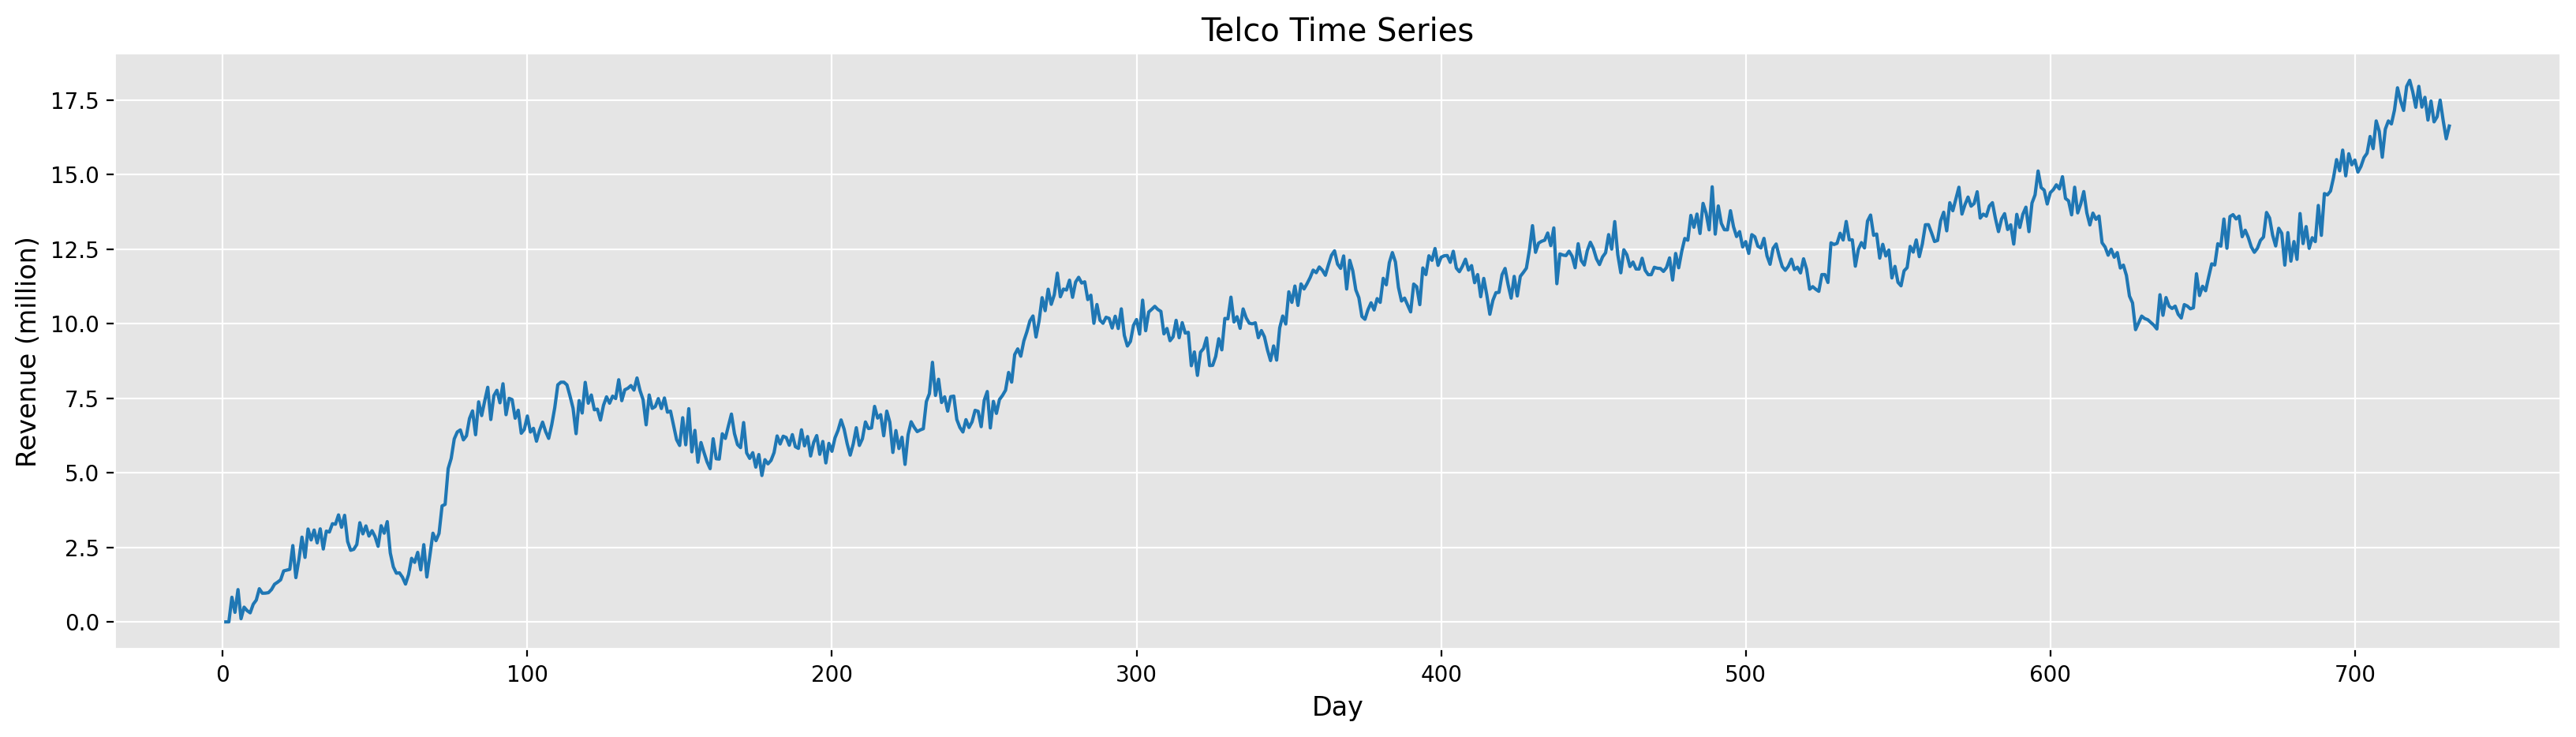

In [4]:
# Plot a line graph for the time series dataset with labels and complete realization of the data
def plot_df(df, x, y, title='', xlabel='Day', ylabel='Revenue (million)', dpi=200):
    plt.figure(figsize=(20, 5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(teleco_df, x=teleco_df['Day'], y=teleco_df['Revenue'], 
        title='Telco Time Series')

In [5]:
# Exploration - Dataframe information
teleco_df.info

<bound method DataFrame.info of      Day    Revenue
0      1   0.000000
1      2   0.000793
2      3   0.825542
3      4   0.320332
4      5   1.082554
..   ...        ...
726  727  16.931559
727  728  17.490666
728  729  16.803638
729  730  16.194813
730  731  16.620798

[731 rows x 2 columns]>

In [6]:
# Exploration - Dataframe variable types
teleco_df.dtypes

Day          int64
Revenue    float64
dtype: object

In [7]:
# Data Cleaning - Check for missing values
print(teleco_df.isnull().values.any())

False


In [8]:
# Data Cleaning - Check for NAN values
print(teleco_df.isna().values.any())

False


In [9]:
# Data Cleaning - Check for duplicate records
print(teleco_df.Day.duplicated().sum())

0


In [10]:
# Exploration - Describe dataframe
print(teleco_df.describe())

              Day     Revenue
count  731.000000  731.000000
mean   366.000000    9.822901
std    211.165812    3.852645
min      1.000000    0.000000
25%    183.500000    6.872836
50%    366.000000   10.785571
75%    548.500000   12.566911
max    731.000000   18.154769


In [11]:
# From statsmodel use adfuller package for stationarity test
adft = adfuller(teleco_df.loc[:, 'Revenue'].values, autolag='AIC')

output_teleco_df = pd.DataFrame({'Values':[adft[0], adft[1], adft[2], adft[3], 
                                 adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                                'Metric':['adf', 'pvalue', 'usedlag',
                                         'nobs', '1% critical value',
                                          '5% critical value', '10% critical value',]})

# Print Adfuller Stationarity results
print(output_teleco_df)

       Values              Metric
0   -1.924612                 adf
1    0.320573              pvalue
2    1.000000             usedlag
3  729.000000                nobs
4   -3.439352   1% critical value
5   -2.865513   5% critical value
6   -2.568886  10% critical value


In [12]:
# Use index function to split data and create training set
teleco_df['Day'] = teleco_df.index
teleco_train = teleco_df.iloc[:len(teleco_df) - 365]

teleco_train['teleco_train'] = teleco_train['Revenue']
del teleco_train['Day']
del teleco_train['Revenue']

In [13]:
# Create test set
teleco_test = teleco_df.iloc[len(teleco_df) - 365:]

# Test Day and Revenue
teleco_test['teleco_test'] = teleco_test['Revenue']
del teleco_test['Day']
del teleco_test['Revenue']

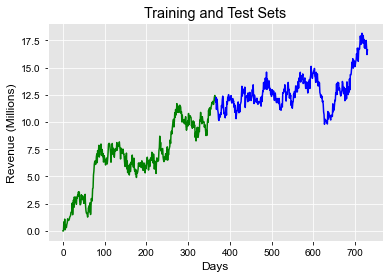

In [14]:
# Plot training and test sets
plt.plot(teleco_train, color='green')
plt.plot(teleco_test, color='blue')
plt.title('Training and Test Sets')
plt.xlabel('Days')
plt.ylabel('Revenue (Millions)')
sns.set()
plt.show()

In [15]:
# Extract Prepared Telco Dataset to CSV
teleco_df.to_csv('prepared_time_series.csv')

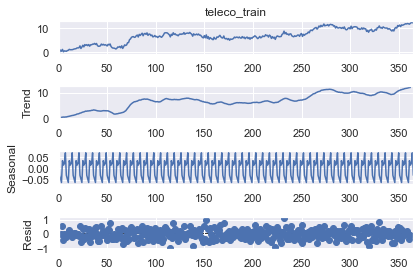

In [16]:
# Prepare for seasonality assessment using statsmodel decompose function
decompose = seasonal_decompose(teleco_train['teleco_train'], model='additive', period=7)
decompose.plot()
plt.show()

Text(0, 0.5, 'Revenue Trend')

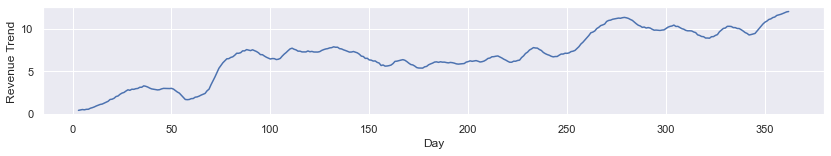

In [17]:
# Decompose and plot Trend
decompose_trend = decompose.trend

ax = decompose_trend.plot(figsize=(14,2))
ax.set_xlabel('Day')
ax.set_ylabel('Revenue Trend')

In [18]:
# Use autocorr feature to calculate autocorrelation with 31 day lag
autocorrelation_lag1 = teleco_df['Revenue'].autocorr(lag=31)
print("Period Lag: 31 days: ", autocorrelation_lag1)

Period Lag: 31 days:  0.8690526347331857


In [19]:
# Recalculate autocorrelation with 62 day and 182 day periods
autocorrelation_lag3 = teleco_df['Revenue'].autocorr(lag=62)
print("Period Lag: 62 days: ", autocorrelation_lag3)

autocorrelation_lag6 = teleco_df['Revenue'].autocorr(lag=182)
print("Period Lag: 182 days: ", autocorrelation_lag6)

Period Lag: 62 days:  0.7758400879703407
Period Lag: 182 days:  0.8139870392893127


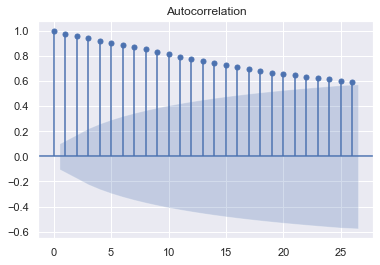

In [20]:
# Use statsmodel to plot autocorrelation function (ACF)
plot_acf(teleco_train)
plt.show()

(array([6.97387711e+03, 3.91439441e+03, 5.47611144e+01, 1.10791953e+01,
        4.25439684e+00, 8.90767103e+00, 9.32436541e+00, 5.07699490e+00,
        4.50820186e+00, 1.97142105e+00, 3.17930644e+00, 2.05465010e+00,
        1.27856111e-01, 9.12357670e-01, 1.58928494e+00, 1.82600308e+00,
        1.37345831e+00, 1.08602805e+00, 3.71664573e-01, 4.01447712e-01,
        6.67019362e-01, 4.28134847e-01, 1.08303874e+00, 5.05461139e-01,
        1.49612021e-01, 2.01156666e-01, 2.01929017e-01, 3.62482513e-02,
        4.74386760e-01, 5.46619399e-01, 2.44460915e-01, 4.75225583e-01,
        2.85007556e-01, 7.59631735e-02, 2.43183009e-01, 7.19503505e-02,
        3.60475608e-01, 2.18971480e-01, 1.23421972e-01, 1.69234109e-01,
        1.69371921e-01, 1.14748035e-01, 2.14144408e-01, 2.82736486e-01,
        3.17059554e-02, 1.62458482e-02, 3.98324693e-02, 6.38895068e-02,
        4.57061837e-02, 6.54718394e-02, 1.72598760e-01, 1.32802101e-01,
        6.74716970e-02, 1.61089989e-02, 1.42266347e-01, 1.236409

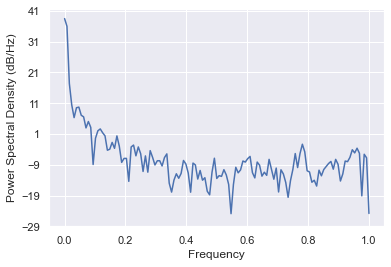

In [21]:
# Calculate and plot power spectral density
plt.psd(teleco_df['Revenue'])

In [22]:
# Set first difference for ARIMA Model
first_diff = teleco_df.diff().dropna()

In [23]:
# Use previously invoked adfuller module from statsmodel on difference
result = adfuller(first_diff['Revenue'])

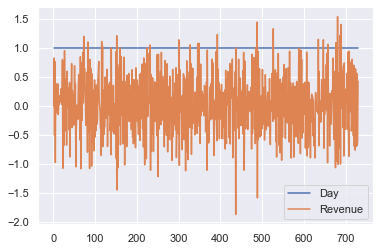

In [24]:
# Create visualization of difference
fig, ax = plt.subplots()
first_diff.plot(ax=ax)
plt.show()

In [25]:
# Print calculated ADF result and pvalue
print('ADF Result:', result[0])
print('pvalue:', result[1])

ADF Result: -44.874527193875984
pvalue: 0.0


In [26]:
# Install pmdarima
!pip install pmdarima

In [42]:
# Perform ARIMA fit on dataset
auto_arima_fit = auto_arima(teleco_df['Revenue'], start_P=1,
                           start_q=1,
                           max_p=3,
                           max_q=3,
                           m=12,
                           seasonal=True,
                           d=None,
                           D=1,
                           trace=True,
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

auto_arima_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=5.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2367.159, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1419.537, Time=1.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1969.738, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2399.547, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1568.311, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1320.755, Time=2.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2339.965, Time=1.01 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1147.041, Time=4.28 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1256.245, Time=2.06 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.98 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.45 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  731
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood                -558.449
Date:                             Fri, 22 Apr 2022   AIC                           1132.898
Time:                                     19:42:44   BIC                           1169.520
Sample:                                          0   HQIC                          1147.037
                                             - 731                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.003      1.779      0.075      -0.001       0.011
ar.L1          1.3864      0.055     25.180      0.000       1.278       1.494
ar.L2          0.0927      0.070      1.325      0.185      -0.044       0.230
ar.L3         -0.4888      0.037    -13.172      0.000      -0.561      -0.416
ma.L1         -0.8941      0.054    -16.578      0.000      -1.000      -0.788
ar.S.L12      -0.7110      0.038    -18.840      0.000      -0.785      -0.637
ar.S.L24      -0.3823      0.039     -9.810      0.000      -0.459      -0.306
sigma2         0.2733      0.016     17.572      0.000       0.243       0.304
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.50   Prob(JB):                         0.33
Heteroskedasticity (H):               1.07   Skew:                             0.01
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Use index to create a dataframe split and remove old entries
teleco_df['Day'] = teleco_df.index
teleco_train = teleco_df.iloc[:len(teleco_df) - 365]

teleco_train['teleco_train'] = teleco_train['Revenue']
del teleco_train['Day']
del teleco_train['Revenue']

In [29]:
# Test telco dataframe set
teleco_test = teleco_df.iloc[len(teleco_df) - 365:]

teleco_test['teleco_test'] = teleco_test['Revenue']
del teleco_test['Day']
del teleco_test['Revenue']

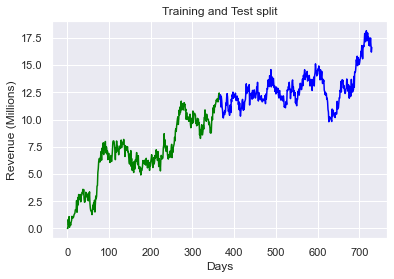

In [30]:
# Plot training and test sets
plt.plot(teleco_train, color='green')
plt.plot(teleco_test, color='blue')
plt.title('Training and Test split')
plt.xlabel('Days')
plt.ylabel('Revenue (Millions)')
sns.set()
plt.show()

In [31]:
# Create SARIMAX model
model = sm.tsa.SARIMAX(teleco_train, 
                      order=(3, 0, 2),
                      seasonal_order=(2, 1, 0, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

SARIMAX_results = model.fit()

# Print SARIMAX Table
print(SARIMAX_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        teleco_train   No. Observations:                  366
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood                -247.972
Date:                             Fri, 22 Apr 2022   AIC                            511.945
Time:                                     19:32:59   BIC                            542.264
Sample:                                          0   HQIC                           524.043
                                             - 366                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3587      0.117     11.635      0.000       1.130       1.588
ar.L2          0.0684      

In [32]:
# Create SARIMAX forecast
result = SARIMAX_results.get_forecast()

# Print forecast analysis
test_1 = teleco_test['teleco_test'].values.astype('float32')
forecast = result.predicted_mean
print('Expected Result: %.2f' % forecast)
print('Forecast Result: %.2f' % test_1[0])
print('Standard Error: %.2f' % result.se_mean)

Expected Result: 12.24
Forecast Result: 11.85
Standard Error: 0.52


In [33]:
# Create four confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
 ci = result.conf_int(alpha=a)
 print('%.1f%% Confidence Interval: %.2f between %.2f and %.2f' % ((1 - a) * 100, forecast, ci['lower teleco_train'], ci['upper teleco_train']))

ci

80.0% Confidence Interval: 12.24 between 11.58 and 12.90
90.0% Confidence Interval: 12.24 between 11.39 and 13.09
95.0% Confidence Interval: 12.24 between 11.23 and 13.25
99.0% Confidence Interval: 12.24 between 10.91 and 13.57


,lower teleco_train,upper teleco_train
366,10.910625,13.567535


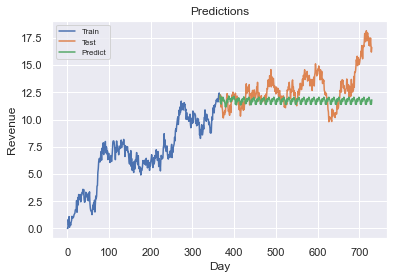

In [34]:
start = len(teleco_train)
end = len(teleco_train) + len(teleco_test) - 1

# SARIMAX Prediction Plot
predictions = SARIMAX_results.predict(start, end, typ = 'levels').rename('Predictions')
plt.plot(teleco_train, label = 'Train')
plt.plot(teleco_test, label = 'Test')
plt.plot(predictions, label = 'Predict')
plt.title('Predictions')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc='upper left', fontsize = 8)
plt.show()

In [35]:
# Use full model to train dataset
model = sm.tsa.statespace.SARIMAX(teleco_df['Revenue'], 
                                  order=(3, 0, 2), 
                                  seasonal_order=(2, 1, 0, 12), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

results = model.fit()

<AxesSubplot:>

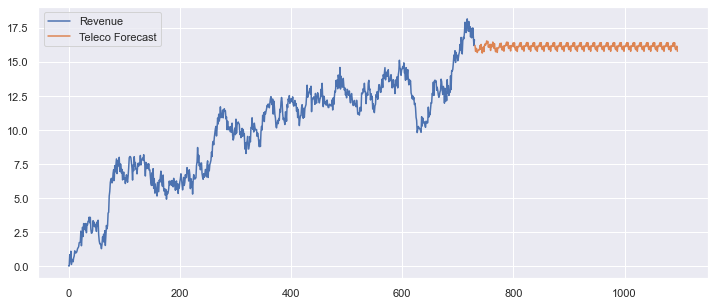

In [36]:
# Create forecast from results
forecast = results.predict(start = len(teleco_df['Revenue']),
                          end = (len(teleco_df['Revenue']) - 1) + 365,
                          typ = 'level').rename('Teleco Forecast')

# Plot forecast
teleco_df['Revenue'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [37]:
# Calculate MSE
MSE = mean_squared_error(teleco_test['teleco_test'], predictions)
print('MSE: ', round(MSE, 4))

MSE:  4.0294


In [38]:
# Calculate RMSE
RMSE = rmse(teleco_test['teleco_test'], predictions)
print('RMSE: ', round(RMSE, 4))

RMSE:  2.0073


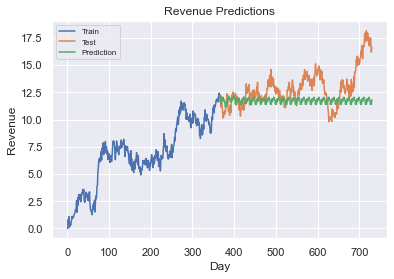

In [39]:
# Create predictions for test set
start = len(teleco_train)
end = len(teleco_train) + len(teleco_test) - 1

# Plot predictions
predictions = SARIMAX_results.predict(start, end, typ = 'levels').rename('Predictions')
plt.plot(teleco_train, label = 'Train')
plt.plot(teleco_test, label = 'Test')
plt.plot(predictions, label = 'Prediction')
plt.title('Revenue Predictions')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend(loc='upper left', fontsize = 8)
plt.show()

<AxesSubplot:>

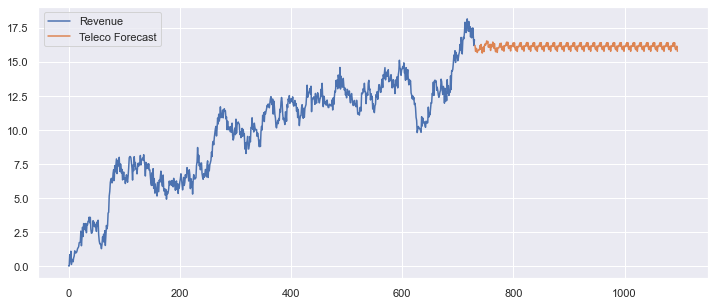

In [40]:
# Create forecast from prediction
forecast = results.predict(start = len(teleco_df['Revenue']),
                          end = (len(teleco_df['Revenue']) - 1) + 365,
                          typ = 'level').rename('Teleco Forecast')

# Plot forecast
teleco_df['Revenue'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)